In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs import encode_float_filename, decode_float_filename

In [2]:
stringFile = encode_float_filename(0.5)
floatFile = decode_float_filename(stringFile)
print(stringFile)
print(floatFile)

5_00e-01.txt
0.5


In [3]:
dbParams = 0.01
direction = "forward"
#dbParams = 0.15
#direction = "backward"
mode = "fixed"
#mode = "adaptive"
alpha = 0.5
lenWindow_list = [30]

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(dbParameter=dbParams, alpha=alpha, mode=mode, direction=direction)
thumbUnit = datasetConverter.getDataUnit('thumb_fr')
#thumbUnit = datasetConverter.getDataUnit('thumb_bk')

========== thumb ============
Forward: Compression rate:0.22314470485360394
========== index ============
Forward: Compression rate:0.24555334544091786
========== middle ============
Forward: Compression rate:0.24907031047306064


In [4]:
for lenWindow in lenWindow_list:
    print(f"================== lenWindow = {lenWindow} =================")
    trainDataAugment = True
    verbose = True

    paramsCA = {}
    paramsCA['lenSource'] = lenWindow
    paramsCA['lenTarget'] = lenWindow
    paramsCA['trainRatio'] = 0.8
    paramsCA['dataAugment'] = trainDataAugment
    paramsCA['smoothFc'] = 1.5
    paramsCA['smoothOrder'] = 3

    #============= Training =============
    trainData, testData = PreparingDatasetCA(thumbUnit, paramsCA, verbose=verbose)
    (sources, lastTranmittedContext) = (trainData[0], trainData[2])
    print(sources.shape)
    print(lastTranmittedContext.shape)
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=verbose)

   

================== lenWindow = 30 =================
Train size: 83253, Test size: 20814
(83193, 30, 3)
(83193, 1, 3)
Size of train loader: 11, Size of test loader: 3
Used device: cuda
Size of model: 50621
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=496, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.8, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=64, out_features=30, bias=True)
    (sigmoid): Sigmoid()
    (trans2traffic_layer): Linear(in_features=94, out_features=

Train size: 83253, Test size: 20814


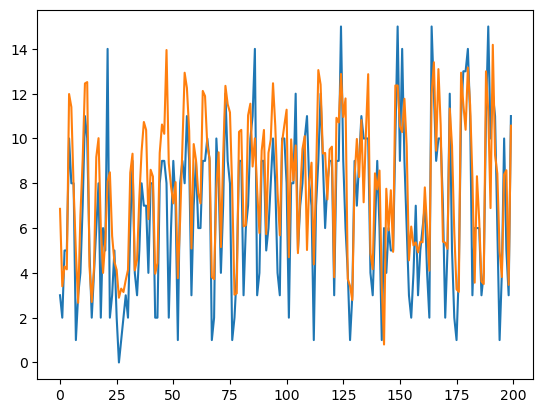

In [5]:
#============= Evaluatation =============
trafficModelCA, _ = createModelCA(modleParametersCA)
trafficModelCA.load_state_dict(bestWeightsCA)
paramsValid = paramsCA.copy()
paramsValid['dataAugment'] = False
trainData, testData = PreparingDatasetCA(thumbUnit, paramsValid, verbose=verbose)
resultsTrain = evaluateModelCA(trafficModelCA, trainData)
resultsTest = evaluateModelCA(trafficModelCA, testData)

#print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

plt.plot(resultsTest['trafficTarget_actual'][0:200])
plt.plot(resultsTest['trafficTarget_predicted'][0:200])
plt.show()

#============= Save Results =============
dbpString = encode_float_filename(dbParams)
with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
    pickle.dump(resultsTrain, file)
with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
    pickle.dump(resultsTest, file)
with open(f"Results/TrafficPredictor/modelParams/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
    pickle.dump(modleParametersCA, file)
torch.save(bestWeightsCA, f"Results/TrafficPredictor/model/{direction}_{lenWindow}_{mode}_{dbpString}.pth")